# Model Exploration
In this notebook, we want to explore different models and their performances:

1. **Load and preprocess data**:
    - Load credit applications and customer data.
    - Merge datasets and create features.
    - Perform minor cleaning and split data into train and test sets based on time.

2. **Feature selection and engineering**:
    - Define various feature groups and combinations.
    - Explore feature sets using Logistic Regression with grid search for hyperparameter tuning.

3. **Model exploration**:
    - Compare different feature sets using Logistic Regression.
    - Evaluate models based on F1 score and visualize ROC curves.

4. **Model training and evaluation**:
    - Train and evaluate Logistic Regression, Random Forest and LightGBM models using the best feature combination.
    - Perform grid search for hyperparameter tuning.
    - Evaluate models using confusion matrix and classification report.
    - Visualize ROC curves for the best models.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# from sklearn.metrics import precision_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# import plotly.express as px
# import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_dark"

from src.models import BaseModel, LogisticRegressionModel, RandomForestModel
from src.processing import IQRClipper, load_csv_data
from src.constants import AggregatedFeatures, RawFeatures
from src.model_visualizations import plot_roc_curve, plot_roc_curves, plot_shap_importance

/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
DEBUG = False
if not DEBUG:
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore')


## Load the merged dataset and create features

In [4]:
df_merged_flights = load_csv_data("../dataset/flights_with_features.csv")

In [6]:
# only take all the features we have created and target
all_features_and_target = [
# static features (converted from categorical to numerical)
RawFeatures.TERMINAL,
RawFeatures.SERVICE_TYPE,
RawFeatures.DEPARTURE_REGION,
RawFeatures.SCHEDULED_DAY_OF_WEEK,
RawFeatures.SCHEDULED_HOUR,
RawFeatures.SCHEDULED_DEPARTURE,
# target
RawFeatures._DELAY_TARGET,
# aggregated features
AggregatedFeatures.AGG_DAILY_AVG_DELAY_OVERALL,
AggregatedFeatures.AGG_DAILY_COUNT_OVERALL,
AggregatedFeatures.AGG_DAILY_AVG_DELAY_TERMINAL,
AggregatedFeatures.AGG_DAILY_COUNT_TERMINAL,
AggregatedFeatures.AGG_DAILY_AVG_DELAY_REGION,
AggregatedFeatures.AGG_DAILY_COUNT_REGION,
AggregatedFeatures.AGG_LAG_DELAY_2H_OVERALL,
AggregatedFeatures.AGG_LAG_DELAY_2H_OVERALL,
AggregatedFeatures.AGG_LAG_DELAY_12H_OVERALL,
AggregatedFeatures.AGG_LAG_DELAY_1D_OVERALL,
]
df_merged_flights = df_merged_flights[all_features_and_target]

### Minor Cleaning and train/test split

In [8]:
from sklearn.utils import resample

# # Ensure the merged DataFrame (df_merged) is sorted by scheduledDeparture
df_merged = df_merged_flights.sort_values('scheduledDeparture')
df_merged = df_merged.dropna()

# Sort by scheduledDeparture to maintain time order
df_merged = df_merged.sort_values('scheduledDeparture')

# Define the split ratio (e.g., 80% train, 20% test)
train_frac = 0.80

# Get the total number of rows
n = len(df_merged)

# Compute the index where training ends
train_end = int(train_frac * n)

# Split the DataFrame
train_df = df_merged.iloc[:train_end].copy()
test_df = df_merged.iloc[train_end:].copy()

# Print out the date ranges for verification
print(f"training data size: {len(train_df)}")
print(f"testing data size: {len(test_df)}")
print("Training period: {} to {}".format(train_df['scheduledDeparture'].min(), train_df['scheduledDeparture'].max()))
print("Testing period: {} to {}".format(test_df['scheduledDeparture'].min(), test_df['scheduledDeparture'].max()))

training data size: 132016
testing data size: 33004
Training period: 2018-01-01 14:35:00+01:00 to 2018-03-08 17:20:00+01:00
Testing period: 2018-03-08 17:25:00+01:00 to 2018-03-24 22:35:00+01:00


In [9]:
train_df[RawFeatures._DELAY_TARGET].value_counts(normalize=True)

delay_target
0    0.631136
1    0.368864
Name: proportion, dtype: float64

### Get features

In [10]:
TARGET = RawFeatures._DELAY_TARGET

## Model exploration with grid search for hyperparameter and feature selection

### Feature search on Logistic Regression

In [17]:
raw_features = [
    RawFeatures.TERMINAL,
    RawFeatures.SERVICE_TYPE,
    RawFeatures.DEPARTURE_REGION,
    RawFeatures.SCHEDULED_HOUR,
    RawFeatures.SCHEDULED_DAY_OF_WEEK,
    ]
agg_features = [
    AggregatedFeatures.AGG_DAILY_AVG_DELAY_OVERALL,
    AggregatedFeatures.AGG_DAILY_COUNT_OVERALL,
    AggregatedFeatures.AGG_DAILY_AVG_DELAY_REGION,
    AggregatedFeatures.AGG_DAILY_COUNT_REGION,
    ]
lag_features = [
    AggregatedFeatures.AGG_LAG_DELAY_2H_OVERALL,
    AggregatedFeatures.AGG_LAG_DELAY_12H_OVERALL,
    AggregatedFeatures.AGG_LAG_DELAY_1D_OVERALL,
]

In [18]:
feature_combinations = {}

# Generate all combinations for each group with at least 2 features
raw_combos = []
for r in range(2, len(raw_features) + 1):
    raw_combos.extend(itertools.combinations(raw_features, r))

agg_combos = []
for r in range(2, len(agg_features) + 1):
    agg_combos.extend(itertools.combinations(agg_features, r))

lag_combos = []
for r in range(0, len(lag_features) + 1):
    lag_combos.extend(itertools.combinations(lag_features, r))

# Combine one combination from raw, one from agg, and one from lag
for raw_combo in raw_combos:
    for lag_combo in lag_combos:
        for agg_combo in agg_combos:
            key = f"raw_{len(raw_combo)}_agg_{len(agg_combo)}_lag_{len(lag_combo)}"
            feature_list = list(raw_combo) + list(lag_combo) + list(agg_combo)
            feature_combinations[key] = feature_list

# Print summary
for name, features in feature_combinations.items():
    print(f"{name}: {[f.value for f in features]}")

raw_2_agg_2_lag_0: ['hour', 'day_of_week', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_3_lag_0: ['hour', 'day_of_week', 'daily_2h_prior_count_overall', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_4_lag_0: ['hour', 'day_of_week', 'daily_2h_prior_avg_delay_overall', 'daily_2h_prior_count_overall', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_2_lag_1: ['hour', 'day_of_week', 'lag_avg_delay_1d_overall', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_3_lag_1: ['hour', 'day_of_week', 'lag_avg_delay_1d_overall', 'daily_2h_prior_count_overall', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_4_lag_1: ['hour', 'day_of_week', 'lag_avg_delay_1d_overall', 'daily_2h_prior_avg_delay_overall', 'daily_2h_prior_count_overall', 'daily_2h_prior_avg_delay_region', 'daily_2h_prior_count_region']
raw_2_agg_2_lag_2: ['hour', 'day_of_week', 'lag_avg_delay_12h_

Features_raw_2_agg_2_lag_0: Recall Score (weighted)= 0.636
Features_raw_2_agg_3_lag_0: Recall Score (weighted)= 0.633
Features_raw_2_agg_4_lag_0: Recall Score (weighted)= 0.633
Features_raw_2_agg_2_lag_1: Recall Score (weighted)= 0.633
Features_raw_2_agg_3_lag_1: Recall Score (weighted)= 0.638
Features_raw_2_agg_4_lag_1: Recall Score (weighted)= 0.636
Features_raw_2_agg_2_lag_2: Recall Score (weighted)= 0.633
Features_raw_2_agg_3_lag_2: Recall Score (weighted)= 0.638
Features_raw_2_agg_4_lag_2: Recall Score (weighted)= 0.636
Features_raw_2_agg_2_lag_3: Recall Score (weighted)= 0.639
Features_raw_2_agg_3_lag_3: Recall Score (weighted)= 0.642
Features_raw_2_agg_4_lag_3: Recall Score (weighted)= 0.638
Features_raw_3_agg_2_lag_0: Recall Score (weighted)= 0.636
Features_raw_3_agg_3_lag_0: Recall Score (weighted)= 0.633
Features_raw_3_agg_4_lag_0: Recall Score (weighted)= 0.633
Features_raw_3_agg_2_lag_1: Recall Score (weighted)= 0.633
Features_raw_3_agg_3_lag_1: Recall Score (weighted)= 0.6

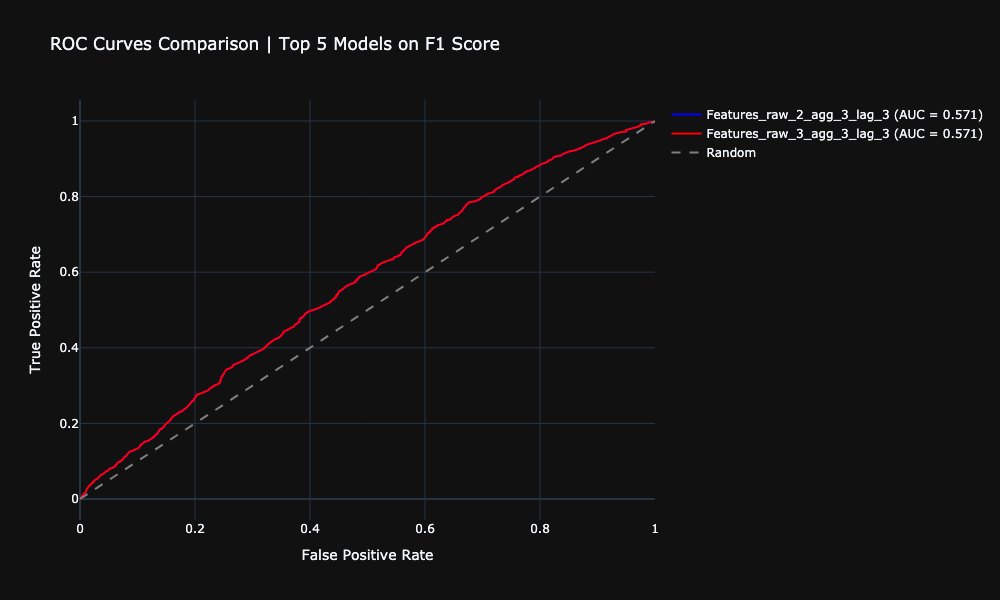

In [29]:
def run_grid_search(X_train, y_train, features, param_grid, cv):
    base_model = BaseModel()
    lr_model = ("lr", LogisticRegression(class_weight="balanced", max_iter=10000))
    pipeline = base_model.create_pipeline(model_step=lr_model)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="recall_weighted", #"f1",
        cv=cv,
        n_jobs=-1
    )
    
    X_train_subset = X_train[features]
    grid_search.fit(X_train_subset, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_,

def compare_feature_sets(df_train, df_test, feature_combinations, param_grid):
    cv = TimeSeriesSplit(n_splits=3)
    results = []
    
    for feature_kind, features_selected in feature_combinations.items():
        X_train = df_train[features_selected]
        y_train = df_train[TARGET]
        X_test  = df_test[features_selected]
        y_test  = df_test[TARGET]
        X_test = X_test.reindex(columns=X_train.columns)
        
        best_model, best_score, best_params = run_grid_search(X_train, y_train, features_selected, param_grid, cv)
        results.append({
            "name": f"Features_{feature_kind}",
            "score": best_score,
            "predictions": best_model.predict_proba(X_test),
            "predicted_labels": best_model.predict(X_test),
            "features": features_selected,
            "best_params": best_params,
        })
        print(f"Features_{feature_kind}: Recall Score (weighted)= {best_score:.3f}")
    
    # Sort by score and take top 5
    top_5_models = sorted(results, key=lambda x: x["score"], reverse=True)[:5]
    
    # Create predictions dict for top models
    model_predictions = {
        model["name"]: model["predictions"] 
        for model in top_5_models
    }
    
    # Plot the confusion matrix and print params, features for the best model out of the top 5
    best_model = top_5_models[0]
    print("Best Model Parameters:", best_model["best_params"])
    print("Best Model Features:", [f.value for f in best_model["features"]])
    # Confusion Matrix
    cm = confusion_matrix(y_test, best_model["predicted_labels"])
    cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print("=== Confusion Matrix (Test) ===")
    print(cm_df)
    print("=== Classification Report (Test) ===")
    print(classification_report(y_test, best_model["predicted_labels"], digits=3))
    
    return plot_roc_curves(y_test, model_predictions, title="ROC Curves Comparison | Top 5 Models on F1 Score") 

# Usage
param_grid_lr = {
    "outlier_clip__factor": [3, 5.0, 7],
    "lr__C": [0.001, 0.01, 0.1, 1]
}

fig = compare_feature_sets(
    train_df, test_df,
    feature_combinations=feature_combinations,
    param_grid=param_grid_lr
)
fig.show()

### Best feature combination

In [23]:
from src.constants import SELECTED_BEST_MODEL_FEATURES
features_selected = SELECTED_BEST_MODEL_FEATURES
X_train = train_df[features_selected]
y_train = train_df[TARGET]
X_test  = test_df[features_selected]
y_test  = test_df[TARGET]

class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()
class_imabalance_weight = class_0_count / class_1_count

## Trying different models with the best feature combination

In [25]:
base_model = BaseModel()
rf_model =("rf", RandomForestClassifier(
                                            class_weight="balanced",
                                            n_estimators=100,
                                            random_state=42
                                        ))
rf_pipeline = base_model.create_pipeline(model_step=rf_model)

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    "outlier_clip__factor": [3.0, 5.0, 10.0],
    "rf__max_depth": [None, 5, 10, 20, 30],
    "rf__n_estimators": [20, 50, 100, 200]
}

grid_search_rf= GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring="f1", #"precision",  # or "average_precision", "recall", etc. for imbalance
    cv=tscv,
    n_jobs=-1
)

# Fit on the training set
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('outlier_clip', IQRClipper(factor=7.0)),
                                       ('scaler', StandardScaler()),
                                       ('var_thresh', VarianceThreshold()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'outlier_clip__factor': [3.0, 5.0, 10.0],
                         'rf__max_depth': [None, 5, 10, 20, 30],
                         'rf__n_estimators': [20, 50, 100, 200]},
             scoring='f1')

Random Forest Best params: {'outlier_clip__factor': 3.0, 'rf__max_depth': 5, 'rf__n_estimators': 100}
Random Forest Best score: 0.509066309388366
=== Random Forest  Confusion Matrix (Test) ===
                 Predicted Negative  Predicted Positive
Actual Negative               16252                5205
Actual Positive                7581                3966
=== Random Forest Classification Report (Test) ===
              precision    recall  f1-score   support

           0      0.682     0.757     0.718     21457
           1      0.432     0.343     0.383     11547

    accuracy                          0.613     33004
   macro avg      0.557     0.550     0.550     33004
weighted avg      0.595     0.613     0.601     33004



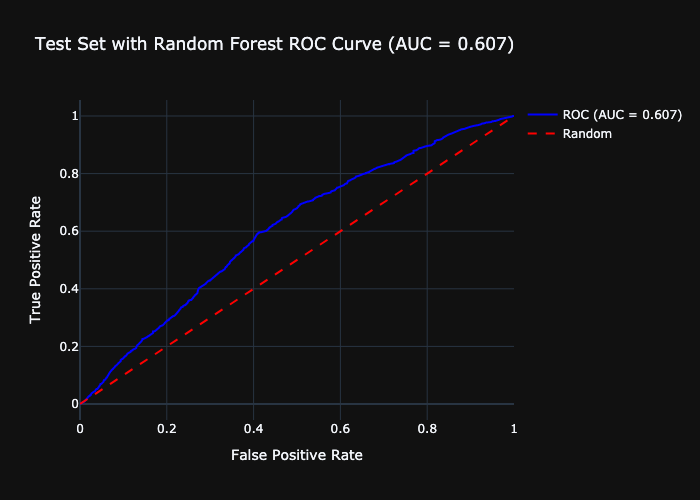

In [26]:
best_pipeline = grid_search_rf.best_estimator_
print("Random Forest Best params:", grid_search_rf.best_params_)
print("Random Forest Best score:", grid_search_rf.best_score_)


y_pred_test = best_pipeline.predict(X_test)
print("=== Random Forest  Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print("=== Random Forest Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=3))

best_model = grid_search_rf.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)
fig = plot_roc_curve(y_test, y_pred_proba, "Test Set with Random Forest ")
fig.show()

### Understand correct threshold

In [30]:
from src.constants import RANDOM_FOREST_PARAMS
from src.models import RandomForestModel

# Fit the model
rf_best_pipeline = RandomForestModel(model_arguments=RANDOM_FOREST_PARAMS).get_pipeline()
rf_best_pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = rf_best_pipeline.predict_proba(X_test)[:, 1]

# Define thresholds
thresholds = [0.2, 0.3, 0.4, 0.5]

# Evaluate for each threshold
for threshold in thresholds:
    y_pred_test = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print(f"=== Confusion Matrix (Test) for threshold {threshold} ===")
    print(cm_df)
    print(f"=== Classification Report (Test) for threshold {threshold} ===")
    print(classification_report(y_test, y_pred_test, digits=3))

=== Confusion Matrix (Test) for threshold 0.2 ===
                 Predicted Negative  Predicted Positive
Actual Negative                   0               21457
Actual Positive                   0               11547
=== Classification Report (Test) for threshold 0.2 ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     21457
           1      0.350     1.000     0.518     11547

    accuracy                          0.350     33004
   macro avg      0.175     0.500     0.259     33004
weighted avg      0.122     0.350     0.181     33004

=== Confusion Matrix (Test) for threshold 0.3 ===
                 Predicted Negative  Predicted Positive
Actual Negative                 925               20532
Actual Positive                 197               11350
=== Classification Report (Test) for threshold 0.3 ===
              precision    recall  f1-score   support

           0      0.824     0.043     0.082     21457
           1      

warnings.filterwarnings("ignore", category=FutureWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.utils\._tags")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.utils\.deprecation")

In [ ]:
from lightgbm import LGBMClassifier
warnings.filterwarnings("ignore", category=FutureWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.utils\._tags")
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn\.utils\.deprecation")
base_model = BaseModel()
lgbm_model = ("lgbm", LGBMClassifier(scale_pos_weight=class_imabalance_weight, random_state=42))
lgbm_pipeline = base_model.create_pipeline(model_step=lgbm_model)

tscv = TimeSeriesSplit(n_splits=3)

param_grid_lgbm = {
    "outlier_clip__factor": [5, 12],            # try different outlier thresholds# how many features to keep
    "lgbm__n_estimators": [50, 100, 200],  # Number of boosting rounds
    "lgbm__max_depth": [-1, 5, 10],  # Tree depth (-1 means unlimited)
    "lgbm__learning_rate": [0.005],  # Learning rate
    "lgbm__scale_pos_weight": [class_imabalance_weight, class_imabalance_weight*1.5],
    "lgbm__pos_bagging_fraction": [0.5, 0.7, 1.0],  # Fraction of positive samples in bagging
    "lgbm__neg_bagging_fraction": [0.1],  # Overall dataset fraction for subsampling
    "lgbm__bagging_freq": [1, 2],  # How often bagging is performed (1 = every boosting round)
    "lgbm__verbosity": [-1],
}

grid_search_lgbm = GridSearchCV(
    lgbm_pipeline,
    param_grid=param_grid_lgbm,
    scoring="f1",
    cv=tscv,
    n_jobs=-1
)
grid_search_lgbm.fit(X_train, y_train)

/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/vaibhavvaidya/.pyenv/versions/3.11.8/envs/flight_delay_prediction_project/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `skle

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('outlier_clip', IQRClipper(factor=7.0)),
                                       ('scaler', StandardScaler()),
                                       ('var_thresh', VarianceThreshold()),
                                       ('lgbm',
                                        LGBMClassifier(random_state=42,
                                                       scale_pos_weight=1.711023492689338))]),
             n_jobs=-1,
             param_grid={'lgbm__bagging_freq': [1, 2],
                         'lgbm__learning_rate': [0.005],
                         'lgbm__max_depth': [-1, 5, 10],
                         'lgbm__n_estimators': [50, 100, 200],
                         'lgbm__neg_bagging_fraction': [0.1],
                         'lgbm__pos_bagging_fraction': [0.5, 0.7, 1.0],
                         'lgbm__scale_pos_weight': [1.711023492689338,
                                                    2.566535239034007],
                         'lgbm__verbosity': [-1],
                         'outlier_clip__factor': [5, 12]},
             scoring='f1')

LightGBM Best params: {'lgbm__bagging_freq': 1, 'lgbm__learning_rate': 0.005, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 100, 'lgbm__neg_bagging_fraction': 0.1, 'lgbm__pos_bagging_fraction': 0.5, 'lgbm__scale_pos_weight': 2.566535239034007, 'lgbm__verbosity': -1, 'outlier_clip__factor': 5}
LightGBM Best score: 0.5412334370961656
=== LightGBM Confusion Matrix (Test) ===
                 Predicted Negative  Predicted Positive
Actual Negative                1541               19916
Actual Positive                 419               11128
=== LightGBM Classification Report (Test) ===
              precision    recall  f1-score   support

           0      0.786     0.072     0.132     21457
           1      0.358     0.964     0.523     11547

    accuracy                          0.384     33004
   macro avg      0.572     0.518     0.327     33004
weighted avg      0.637     0.384     0.268     33004



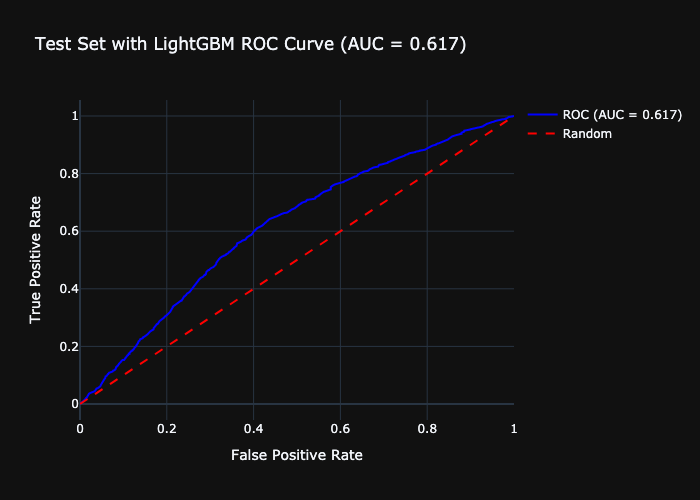

In [32]:
best_pipeline = grid_search_lgbm.best_estimator_
print("LightGBM Best params:", grid_search_lgbm.best_params_)
print("LightGBM Best score:", grid_search_lgbm.best_score_)


y_pred_test = best_pipeline.predict(X_test)
print("=== LightGBM Confusion Matrix (Test) ===")
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
print(cm_df)
print("=== LightGBM Classification Report (Test) ===")
print(classification_report(y_test, y_pred_test, digits=3))

best_model = grid_search_lgbm.best_estimator_
y_pred_proba2 = best_model.predict_proba(X_test)
fig = plot_roc_curve(y_test, y_pred_proba2, "Test Set with LightGBM ")
fig.show()

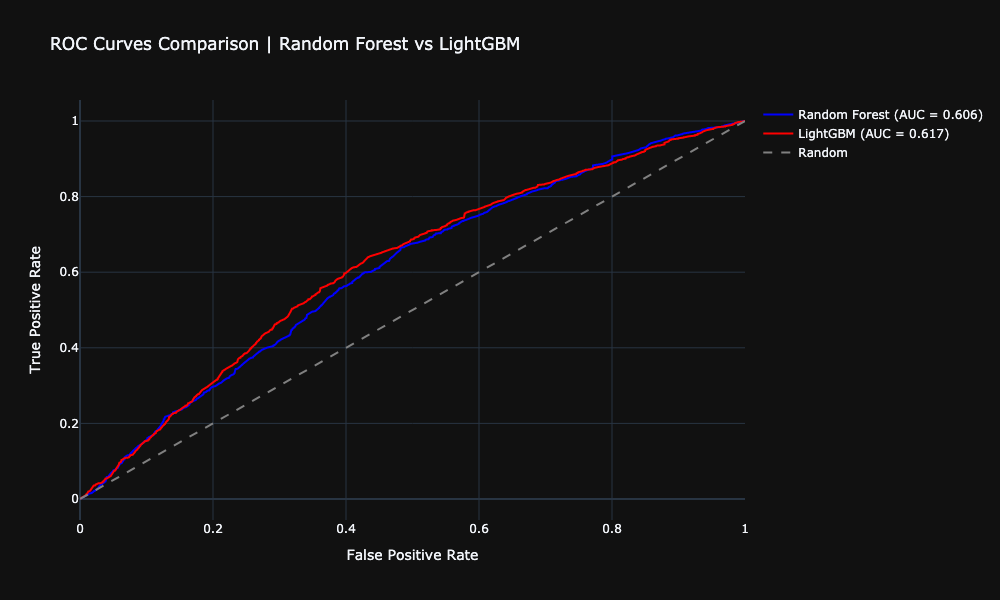

In [33]:
both_predictions = {
    "Random Forest": rf_best_pipeline.predict_proba(X_test),
    "LightGBM": y_pred_proba2
}
plot_roc_curves(y_test, both_predictions, title="ROC Curves Comparison | Random Forest vs LightGBM")

### Investigate shap values for features - TBD

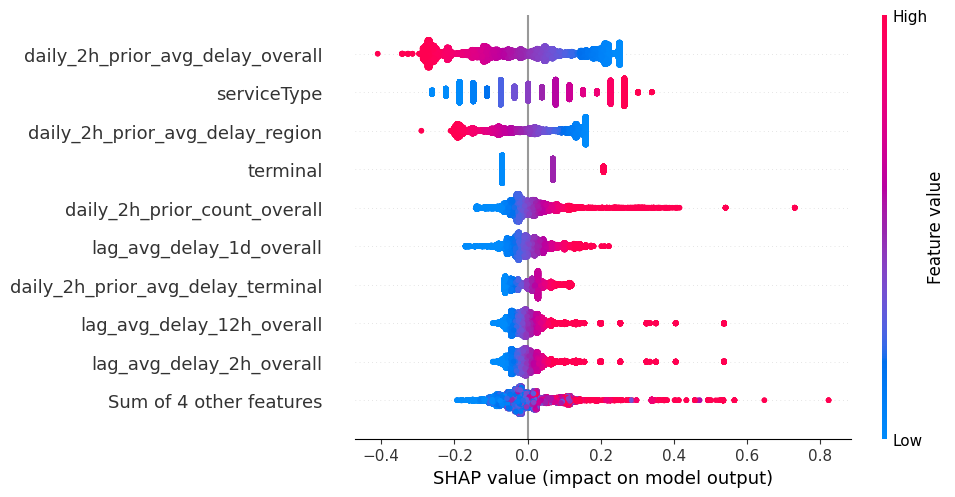

<Figure size 640x480 with 0 Axes>

In [44]:
# Reset index to avoid dimension mismatch
X_test_subset = test_df[features_selected].reset_index(drop=True)
model_arguments = {"C": 0.01, "class_weight": "balanced", "max_iter": 10000}
lr_pipeline = LogisticRegressionModel(model_arguments=model_arguments).get_pipeline()
lr_pipeline.fit(X_train, y_train)
shap_fig = plot_shap_importance(
    pipeline=lr_pipeline, 
    X=X_test_subset, 
    feature_names=[f.value for f in features_selected]
    )
shap_fig.show()